# DS3 Kaggle Workshop - Advanced Practices in Pandas

Welcome to our Advanced Practices in Pandas Jupyter Notebook. With our interactive problems, we hope to guide you in your learning process. Here, you can practice useful pandas functions for DataFrame manipulation and analysis. Have fun!

The dataset we will be using is called “Uber and Lyft Cab Prices” from Kaggle. Here is the link to the dataset: https://www.kaggle.com/ravi72munde/uber-lyft-cab-prices?select=weather.csv. For your convenience, we have downloaded it into the same repository as this Jupyter Notebook for you.

**Note:** The slideshow presentation will be published after the workshop. This will allow you to look back at the material covered and go over concepts that we were not able to get to during the timeframe.

## Importing Libraries and the Dataset

In [8]:
import pandas as pd
import numpy as np
import time

In [9]:
cab_rides = pd.read_csv('cab_rides.csv')
cab_rides

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL
...,...,...,...,...,...,...,...,...,...,...
693066,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
693067,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX
693068,1.00,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
693069,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV


In [10]:
weather = pd.read_csv('weather.csv')
weather

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.00,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.00,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.00,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.00,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.00,1012.14,0.1786,1545003901,0.75,11.49
...,...,...,...,...,...,...,...,...
6271,44.72,North Station,0.89,1000.69,NaN,1543819974,0.96,1.52
6272,44.85,Northeastern University,0.88,1000.71,NaN,1543819974,0.96,1.54
6273,44.82,South Station,0.89,1000.70,NaN,1543819974,0.96,1.54
6274,44.78,Theatre District,0.89,1000.70,NaN,1543819974,0.96,1.54


## Concatenation
[`pd.concat()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) method: appends, or concatenates, two or more dataframes.
* Can be concatenated vertically (one atop another), which is default (axis = 0)
* Can also be concatenated horizontally (side-by-side) (axis = 1)

In [11]:
cab_rides.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [12]:
weather.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind'],
      dtype='object')

Argument for concat is an Iterable with elements of type DataFrame. 

In [13]:
# axis = 1 for concat horizontally
pd.concat([cab_rides, weather], axis = 1)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,42.42,Back Bay,1.0,1012.14,0.1228,1.545004e+09,0.77,11.25
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,42.43,Beacon Hill,1.0,1012.15,0.1846,1.545004e+09,0.76,11.32
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,42.50,Boston University,1.0,1012.15,0.1089,1.545004e+09,0.76,11.07
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,42.11,Fenway,1.0,1012.13,0.0969,1.545004e+09,0.77,11.09
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,43.13,Financial District,1.0,1012.14,0.1786,1.545004e+09,0.75,11.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693066,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693067,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693068,1.00,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693069,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need to do a little bit of work if we want to be able to use concat. Simply putting one table atop another, or side-by-side does not help us analyze our data. More specifically, if we want to concatenate the tables horizontally, simply doing the code in the previous cell will not work because the locations in the cab_rides rows and weather rows will not correspond to one another. There will be a mismatch!

Does it make more sense to concatenate vertically or horizontally with these datsets?
* Vertically (axis = 0)
* Horizontally (axis = 1)

In order to concatenate the datasets, there needs to be commonality in the corresponding rows of the two dataframes. Moreover, the number of rows should be equal, otherwise you'll have a lot of NaN values after concatenating. Which column does it make sense to append from the two data sets?

In [14]:
cab_rides.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [15]:
weather.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind'],
      dtype='object')

In [16]:
def convert_unix_epoch_to_EST(epoch_time_sec):
    epoch_time_sec = epoch_time_sec - 5 * 60 * 60   # subtract 3 hours because EST is GMT/UTC -5
    return time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(epoch_time_sec))

In [17]:
cab_rides['time_stamp'] = cab_rides['time_stamp'] / 1000.0 # cab_rides timestamps were in ms, so convert to sec first
cab_rides['time_stamp'] = cab_rides['time_stamp'].apply(convert_unix_epoch_to_EST) # apply function along column
weather['time_stamp'] = weather['time_stamp'].apply(convert_unix_epoch_to_EST) # weather timestamps already in sec

In [18]:
cab_rides.head(3)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,2018-12-16 04:30:07,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,2018-11-26 21:00:23,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,2018-11-27 20:00:22,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft


In [19]:
weather.head(3)

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,2018-12-16 18:45:01,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,2018-12-16 18:45:01,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,2018-12-16 18:45:01,0.76,11.07


In [20]:
cab_rides.get('time_stamp').min()

'2018-11-25 22:40:46'

In [21]:
cab_rides.get('time_stamp').max()

'2018-12-18 14:15:10'

In [22]:
len(cab_rides.get('time_stamp'))

693071

In [23]:
weather.get('time_stamp').min()

'2018-11-25 22:40:44'

In [24]:
weather.get('time_stamp').max()

'2018-12-18 13:45:02'

In [25]:
len(weather.get('time_stamp'))

6276

We can foresee a problem if we choose to concatenate the dataframes. The cab_rides and weather timestamps will not match, and this will hinder our analysis. We can try concatenating and observe this.

In [26]:
cab_rides = cab_rides.sort_values(by = 'time_stamp').reset_index(drop = True)
cab_rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX
1,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft
3,2.66,Lyft,2018-11-25 22:40:46,Beacon Hill,Boston University,19.5,1.0,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,lyft_premier,Lux
4,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared


In [27]:
weather = weather.sort_values(by = 'time_stamp').reset_index(drop = True)
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,40.84,West End,0.87,1014.40,NaN,2018-11-25 22:40:44,0.93,1.52
1,40.98,Haymarket Square,0.87,1014.40,NaN,2018-11-25 22:40:44,0.92,1.57
2,40.86,South Station,0.87,1014.39,NaN,2018-11-25 22:40:44,0.93,1.60
3,40.81,Northeastern University,0.89,1014.35,NaN,2018-11-25 22:40:44,0.93,1.36
4,41.04,Back Bay,0.87,1014.39,NaN,2018-11-25 22:40:45,0.92,1.46


In [28]:
pd.concat([cab_rides, weather], axis = 1).head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,40.84,West End,0.87,1014.40,NaN,2018-11-25 22:40:44,0.93,1.52
1,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,40.98,Haymarket Square,0.87,1014.40,NaN,2018-11-25 22:40:44,0.92,1.57
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft,40.86,South Station,0.87,1014.39,NaN,2018-11-25 22:40:44,0.93,1.60
3,2.66,Lyft,2018-11-25 22:40:46,Beacon Hill,Boston University,19.5,1.0,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,lyft_premier,Lux,40.81,Northeastern University,0.89,1014.35,NaN,2018-11-25 22:40:44,0.93,1.36
4,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared,41.04,Back Bay,0.87,1014.39,NaN,2018-11-25 22:40:45,0.92,1.46


Problem that we predicted earlier: the time_stamps for cab_rides and weather do not match, and the locations do not match either! Let's try another approach since `pd.concat()` does not seem to be effective.

## Merging Dataframes
[`pd.merge()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) method:

In [29]:
pd.merge(cab_rides, weather, on = ['time_stamp']).head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,humidity,wind
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,40.84,Fenway,0.88,1014.35,NaN,0.93,1.31
1,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,41.02,North End,0.87,1014.40,NaN,0.92,1.59
2,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,40.84,Fenway,0.88,1014.35,NaN,0.93,1.31
3,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,41.02,North End,0.87,1014.40,NaN,0.92,1.59
4,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft,40.84,Fenway,0.88,1014.35,NaN,0.93,1.31


In [30]:
rideshare_and_weather = pd.merge(cab_rides, weather, left_on = ['time_stamp', 'source'], right_on = ['time_stamp', 'location']).head()
rideshare_and_weather

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,humidity,wind
0,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft,41.02,North End,0.87,1014.40,NaN,0.92,1.59
1,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared,41.02,North End,0.87,1014.40,NaN,0.92,1.59
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,13.5,1.0,9e6a67e6-9628-4fb1-94e5-bf426f61b038,lyft_premier,Lux,41.02,North End,0.87,1014.40,NaN,0.92,1.59
3,1.23,Lyft,2018-11-25 22:40:46,West End,North End,19.5,1.0,a8b37ec2-b380-47da-8269-590dfaaffdbf,lyft_lux,Lux Black,41.02,North End,0.87,1014.40,NaN,0.92,1.59
4,2.96,Lyft,2018-11-25 22:40:46,Theatre District,Fenway,11.0,1.0,52d51d09-725b-4f57-b866-382c152cdb92,lyft,Lyft,40.84,Fenway,0.88,1014.35,NaN,0.93,1.31


**TODO**: explain the types of joins

In [31]:
pd.merge(cab_rides, weather, left_on = ['time_stamp', 'source'], right_on = ['time_stamp', 'location'], how = 'outer', indicator = True).head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,humidity,wind,_merge
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,3.05,Uber,2018-11-25 22:40:46,Fenway,North Station,10.5,1.0,f67b0a6b-08f9-43bb-b47d-efad7310d4c7,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,2.01,Lyft,2018-11-25 22:40:46,South Station,North Station,16.5,1.0,65e9134a-dff4-45b9-81e3-90ba4cae702f,lyft_premier,Lux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,2.71,Uber,2018-11-25 22:40:46,Fenway,Theatre District,19.5,1.0,8682f9bf-5cc0-4dfc-b8fe-4e22070d1684,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In general, `pd.concat()` is preferable over `pd.merge()` whenever you want to consolidate more than two dataframes. You cannot do this in `pd.merge()` unless you merge two dataframes and then merge a third dataframe to the merged dataframe, which often gets complicated.

**TODO**: explain the difference between merge and join

**TODO**: for Blake: it would be interesting to have a practice problem for the students using the merged dataframe I made: A problem along the lines of: 
- How does it seem like the **number** of rides are affected by the type of weather? (something related to a groupby count)
- Is there a relation between the surge multiplier of the ride and the weather quality?

## Transpose

In [32]:
ten_cabs= cab_rides.head(10)
ten_cabs

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX
1,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft
3,2.66,Lyft,2018-11-25 22:40:46,Beacon Hill,Boston University,19.5,1.0,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,lyft_premier,Lux
4,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared
5,1.23,Lyft,2018-11-25 22:40:46,West End,North End,13.5,1.0,9e6a67e6-9628-4fb1-94e5-bf426f61b038,lyft_premier,Lux
6,1.23,Lyft,2018-11-25 22:40:46,West End,North End,19.5,1.0,a8b37ec2-b380-47da-8269-590dfaaffdbf,lyft_lux,Lux Black
7,1.69,Lyft,2018-11-25 22:40:46,West End,South Station,10.5,1.0,e522a70b-efdb-4112-b7f0-37232fc88deb,lyft,Lyft
8,2.30,Lyft,2018-11-25 22:40:46,Boston University,Beacon Hill,9.0,1.0,d3d168df-a1b6-4de3-b1a1-7d1fb464bd41,lyft,Lyft
9,2.96,Lyft,2018-11-25 22:40:46,Theatre District,Fenway,11.0,1.0,52d51d09-725b-4f57-b866-382c152cdb92,lyft,Lyft


In [33]:
ten_cabs_transpose = ten_cabs.transpose() #same as .T
ten_cabs_transpose

,0,1,2,3,4,5,6,7,8,9
distance,0.56,1.57,1.23,2.66,1.23,1.23,1.23,1.69,2.3,2.96
cab_type,Uber,Uber,Lyft,Lyft,Lyft,Lyft,Lyft,Lyft,Lyft,Lyft
time_stamp,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46,2018-11-25 22:40:46
destination,Haymarket Square,North End,West End,Beacon Hill,West End,West End,West End,West End,Boston University,Theatre District
source,North Station,Theatre District,North End,Boston University,North End,North End,North End,South Station,Beacon Hill,Fenway
price,7,NaN,7,19.5,5,13.5,19.5,10.5,9,11
surge_multiplier,1,1,1,1,1,1,1,1,1,1
id,a7b50600-c6c5-4e6c-bea9-4487344196d4,9962f244-8fce-4ae9-a583-139d5d7522e1,4aa68a5d-abc0-4fdf-a47f-0003617afbae,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,89f35ef7-7129-483d-b3e6-d89afdf6946d,9e6a67e6-9628-4fb1-94e5-bf426f61b038,a8b37ec2-b380-47da-8269-590dfaaffdbf,e522a70b-efdb-4112-b7f0-37232fc88deb,d3d168df-a1b6-4de3-b1a1-7d1fb464bd41,52d51d09-725b-4f57-b866-382c152cdb92
product_id,55c66225-fbe7-4fd5-9072-eab1ece5e23e,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,lyft,lyft_premier,lyft_line,lyft_premier,lyft_lux,lyft,lyft,lyft
name,UberX,Taxi,Lyft,Lux,Shared,Lux,Lux Black,Lyft,Lyft,Lyft


In [34]:
weather_transpose = weather.T # same as .transpose()
weather_transpose

,0,1,2,3,4,5,6,7,8,9,...,6266,6267,6268,6269,6270,6271,6272,6273,6274,6275
temp,40.84,40.98,40.86,40.81,41.04,41.02,41.07,40.95,40.94,40.8,...,30.91,31.2,30.81,30.93,30.79,30.83,31.19,30.93,30.96,30.8
location,West End,Haymarket Square,South Station,Northeastern University,Back Bay,Beacon Hill,Boston University,Financial District,North Station,Theatre District,...,Northeastern University,South Station,Theatre District,Back Bay,West End,North Station,Financial District,Fenway,Boston University,Beacon Hill
clouds,0.87,0.87,0.87,0.89,0.87,0.87,0.86,0.89,0.89,0.87,...,0,0,0,0,0,0,0,0,0,0
pressure,1014.4,1014.4,1014.39,1014.35,1014.39,1014.39,1014.39,1014.35,1014.35,1014.39,...,1012.34,1012.31,1012.32,1012.33,1012.32,1012.32,1012.31,1012.35,1012.35,1012.32
rain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_stamp,2018-11-25 22:40:44,2018-11-25 22:40:44,2018-11-25 22:40:44,2018-11-25 22:40:44,2018-11-25 22:40:45,2018-11-25 22:40:45,2018-11-25 22:40:45,2018-11-25 22:40:45,2018-11-25 22:40:45,2018-11-25 22:40:45,...,2018-12-18 13:45:01,2018-12-18 13:45:01,2018-12-18 13:45:01,2018-12-18 13:45:01,2018-12-18 13:45:02,2018-12-18 13:45:02,2018-12-18 13:45:02,2018-12-18 13:45:02,2018-12-18 13:45:02,2018-12-18 13:45:02
humidity,0.93,0.92,0.93,0.93,0.92,0.92,0.92,0.93,0.92,0.93,...,0.46,0.45,0.46,0.46,0.46,0.46,0.45,0.45,0.45,0.46
wind,1.52,1.57,1.6,1.36,1.46,1.5,1.36,1.49,1.43,1.55,...,13.06,13.19,13.15,13.06,13.09,13.09,13.18,12.99,12.93,13.08


In [35]:
# practice problem on merged or joined dataset

## Groupby

In [36]:
# total distance miles done based on cab_type
sum_distance = cab_rides.groupby('cab_type')[['distance']].sum()
sum_distance

,distance
cab_type,
Lyft,672293.79
Uber,845136.48


In [37]:
# total spent on cab_type
sum_price = cab_rides.groupby('cab_type')[['price']].sum()
sum_price

,price
cab_type,
Lyft,5333957.98
Uber,5221435.00


In [38]:
# average temperature based on location
weather.groupby('location')[['temp']].mean()

,temp
location,
Back Bay,39.082122
Beacon Hill,39.047285
Boston University,39.047744
Fenway,38.964379
Financial District,39.410822
Haymarket Square,39.067897
North End,39.090841
North Station,39.035315
Northeastern University,38.975086


In [39]:
# averages based on location
weather.groupby('location').mean()

,temp,clouds,pressure,rain,humidity,wind
location,,,,,,
Back Bay,39.082122,0.678432,1008.447820,0.056012,0.764073,6.778528
Beacon Hill,39.047285,0.677801,1008.448356,0.057097,0.765048,6.810325
Boston University,39.047744,0.679235,1008.459254,0.054688,0.763786,6.692180
Fenway,38.964379,0.679866,1008.453289,0.054863,0.767266,6.711721
Financial District,39.410822,0.676730,1008.435793,0.061352,0.754837,6.860019
Haymarket Square,39.067897,0.676711,1008.445239,0.059593,0.764837,6.843193
North End,39.090841,0.676730,1008.441912,0.058712,0.764054,6.853117
North Station,39.035315,0.676998,1008.442811,0.056543,0.765545,6.835755
Northeastern University,38.975086,0.678317,1008.444168,0.054197,0.767648,6.749426


In [40]:
# practice problem on merged or joined dataset

## Aggregate

## Apply
Let's get into the details of `pd.apply()` which enables us to apply a function along an axis of a DataFrame.

* Objects passed to the function are Series objects whose index is either the DataFrame’s index (axis=0) or the DataFrame’s columns (axis=1).

In [41]:
def toft(df):
    ft = df * 5280
    return ft

In [42]:
miles = cab_rides[['distance']]
feet = miles.apply(toft)

#reassign to original dataframe 
cab_rides = cab_rides.assign(distance_ft = feet)
cab_rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,distance_ft
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2956.8
1,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,8289.6
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft,6494.4
3,2.66,Lyft,2018-11-25 22:40:46,Beacon Hill,Boston University,19.5,1.0,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,lyft_premier,Lux,14044.8
4,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared,6494.4


In [43]:
cab_rides['distance_ft2'] = cab_rides['distance'].apply(toft)
cab_rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,distance_ft,distance_ft2
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2956.8,2956.8
1,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,8289.6,8289.6
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft,6494.4,6494.4
3,2.66,Lyft,2018-11-25 22:40:46,Beacon Hill,Boston University,19.5,1.0,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,lyft_premier,Lux,14044.8,14044.8
4,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared,6494.4,6494.4


In [44]:
cab_rides = cab_rides.drop(columns = 'distance_ft2')

## Lambda
 `pd.apply(lambda x:())` functions are defined using the keyword lambda. The function has only one expression and any number of arguements. A lambda function cannot contain any statements, and it returns a function object which can be assigned to any variable.

*  Allows for application of a custom function to satisy a goal during data manipulation such as developing a unique DataFrame column.
*  Useful for small tasks with less code. 

In [45]:
def timeofday(x):
     if  x < 12:
        return 'Morning'
     elif 12<= x <18:
        return "Afternoon"
     else:
        return "Evening"

In [46]:
type(cab_rides['time_stamp'][0])

str

In [47]:
cabtime= pd.to_datetime(cab_rides['time_stamp'])
dft = pd.DataFrame(data=cabtime)
dft #new DataFrame time in datetime format

,time_stamp
0,2018-11-25 22:40:46
1,2018-11-25 22:40:46
2,2018-11-25 22:40:46
3,2018-11-25 22:40:46
4,2018-11-25 22:40:46
...,...
693066,2018-12-18 14:15:10
693067,2018-12-18 14:15:10
693068,2018-12-18 14:15:10
693069,2018-12-18 14:15:10


In [48]:
cab_rides['time_stamp'] = dft['time_stamp']

In [49]:
import time
a = time.time()
cab_rides['time_of_day'] = cab_rides.time_stamp.dt.hour.apply(lambda row: timeofday(row))
b= time.time()
b-a

0.19576764106750488

In [50]:
cab_rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,distance_ft,time_of_day
0,0.56,Uber,2018-11-25 22:40:46,Haymarket Square,North Station,7.0,1.0,a7b50600-c6c5-4e6c-bea9-4487344196d4,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2956.8,Evening
1,1.57,Uber,2018-11-25 22:40:46,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,8289.6,Evening
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft,6494.4,Evening
3,2.66,Lyft,2018-11-25 22:40:46,Beacon Hill,Boston University,19.5,1.0,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,lyft_premier,Lux,14044.8,Evening
4,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared,6494.4,Evening


### Timing
When analyzing data, always have a plan of action. A difficult route could cost you a lot of time. Let's look at two ways of simplifying a variable for ease of use and further application.  

In [51]:
def tod(time):
    t = time.str[11:13]
    tint = [int(x) for x in t]
    for i, x in enumerate(tint):
        if  x < 12:
             tint[i] = 'Morning'
        elif 12<= x <18:
            tint[i] = "Afternoon"
        else:
            tint[i] = "Evening"
    return tint

weather.time_stamp.str[11:13]

0       22
1       22
2       22
3       22
4       22
        ..
6271    13
6272    13
6273    13
6274    13
6275    13
Name: time_stamp, Length: 6276, dtype: object

In [52]:
a = time.time()
weather['Timeofday'] = tod(weather['time_stamp'])
b= time.time()
b-a, weather.head()

(0.0065670013427734375,
     temp                 location  clouds  pressure  rain  \
 0  40.84                 West End    0.87   1014.40   NaN   
 1  40.98         Haymarket Square    0.87   1014.40   NaN   
 2  40.86            South Station    0.87   1014.39   NaN   
 3  40.81  Northeastern University    0.89   1014.35   NaN   
 4  41.04                 Back Bay    0.87   1014.39   NaN   
 
             time_stamp  humidity  wind Timeofday  
 0  2018-11-25 22:40:44      0.93  1.52   Evening  
 1  2018-11-25 22:40:44      0.92  1.57   Evening  
 2  2018-11-25 22:40:44      0.93  1.60   Evening  
 3  2018-11-25 22:40:44      0.93  1.36   Evening  
 4  2018-11-25 22:40:45      0.92  1.46   Evening  )

In [53]:
weather['time_stamp'] = pd.to_datetime(weather['time_stamp'])
a = time.time()
weather['timeofday'] = weather['time_stamp'].dt.hour.apply(lambda row : timeofday(row))
b = time.time()
b-a, weather.head()

(0.004083871841430664,
     temp                 location  clouds  pressure  rain          time_stamp  \
 0  40.84                 West End    0.87   1014.40   NaN 2018-11-25 22:40:44   
 1  40.98         Haymarket Square    0.87   1014.40   NaN 2018-11-25 22:40:44   
 2  40.86            South Station    0.87   1014.39   NaN 2018-11-25 22:40:44   
 3  40.81  Northeastern University    0.89   1014.35   NaN 2018-11-25 22:40:44   
 4  41.04                 Back Bay    0.87   1014.39   NaN 2018-11-25 22:40:45   
 
    humidity  wind Timeofday timeofday  
 0      0.93  1.52   Evening   Evening  
 1      0.92  1.57   Evening   Evening  
 2      0.93  1.60   Evening   Evening  
 3      0.93  1.36   Evening   Evening  
 4      0.92  1.46   Evening   Evening  )

In [54]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,Timeofday,timeofday
0,40.84,West End,0.87,1014.40,NaN,2018-11-25 22:40:44,0.93,1.52,Evening,Evening
1,40.98,Haymarket Square,0.87,1014.40,NaN,2018-11-25 22:40:44,0.92,1.57,Evening,Evening
2,40.86,South Station,0.87,1014.39,NaN,2018-11-25 22:40:44,0.93,1.60,Evening,Evening
3,40.81,Northeastern University,0.89,1014.35,NaN,2018-11-25 22:40:44,0.93,1.36,Evening,Evening
4,41.04,Back Bay,0.87,1014.39,NaN,2018-11-25 22:40:45,0.92,1.46,Evening,Evening


While the calculation times of the two methods were quite similar, the actual time to code was much longer (double in this case !!!). Make sure to understand the particular data type you are working with and various functions available to you.

### When to Rideshare
Obviously sometimes you have to Uber and cannot wait for the time to be just right. Despite this fact, let's attempt to find the optimal weather to Uber or Lyft in terms of surge using the  `rideshare_and_weather` DataFrame. 

In [55]:
rideshare_and_weather = pd.merge(cab_rides, weather, left_on = ['time_stamp', 'source'], right_on = ['time_stamp', 'location'])
rideshare_and_weather.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,time_of_day,temp,location,clouds,pressure,rain,humidity,wind,Timeofday,timeofday
0,1.23,Lyft,2018-11-25 22:40:46,West End,North End,7.0,1.0,4aa68a5d-abc0-4fdf-a47f-0003617afbae,lyft,Lyft,...,Evening,41.02,North End,0.87,1014.40,NaN,0.92,1.59,Evening,Evening
1,1.23,Lyft,2018-11-25 22:40:46,West End,North End,5.0,1.0,89f35ef7-7129-483d-b3e6-d89afdf6946d,lyft_line,Shared,...,Evening,41.02,North End,0.87,1014.40,NaN,0.92,1.59,Evening,Evening
2,1.23,Lyft,2018-11-25 22:40:46,West End,North End,13.5,1.0,9e6a67e6-9628-4fb1-94e5-bf426f61b038,lyft_premier,Lux,...,Evening,41.02,North End,0.87,1014.40,NaN,0.92,1.59,Evening,Evening
3,1.23,Lyft,2018-11-25 22:40:46,West End,North End,19.5,1.0,a8b37ec2-b380-47da-8269-590dfaaffdbf,lyft_lux,Lux Black,...,Evening,41.02,North End,0.87,1014.40,NaN,0.92,1.59,Evening,Evening
4,2.96,Lyft,2018-11-25 22:40:46,Theatre District,Fenway,11.0,1.0,52d51d09-725b-4f57-b866-382c152cdb92,lyft,Lyft,...,Evening,40.84,Fenway,0.88,1014.35,NaN,0.93,1.31,Evening,Evening


In [56]:
def surge_type(x):
    if x > 1.0:
        return 'SURGE'
    else:
        return 'Normal'
        

In [57]:
rideshare_and_weather['surge_type']= rideshare_and_weather.apply(lambda x: surge_type(x['surge_multiplier']),axis=1)

In [58]:
surge = rideshare_and_weather[rideshare_and_weather['surge_type'] == 'SURGE'].sort_values(by = 'time_stamp')\
.reset_index(drop = True)
normal = rideshare_and_weather[rideshare_and_weather['surge_type'] == 'Normal'].sort_values(by = 'time_stamp')\
.reset_index(drop = True)

Take a look at the surge and normal rows to determine if their is an obvious discrepency between the two at the unique time of day. 

In [60]:
S = surge.groupby('timeofday').mean()
S

,distance,price,surge_multiplier,distance_ft,temp,clouds,pressure,rain,humidity,wind
timeofday,,,,,,,,,,
Afternoon,2.560000,35.925000,1.650000,13516.800000,43.040500,0.950000,1001.082000,0.003367,0.752500,8.863500
Evening,2.608727,29.481818,1.531818,13774.080000,38.492182,0.610364,998.204182,0.046820,0.723091,9.515091
Morning,2.218571,25.300000,1.410714,11714.057143,38.252857,0.629429,1001.614000,NaN,0.820286,4.862286


In [61]:
N = normal.groupby('timeofday').mean()
N

,distance,price,surge_multiplier,distance_ft,temp,clouds,pressure,rain,humidity,wind
timeofday,,,,,,,,,,
Afternoon,2.110676,16.411631,1.0,11144.369577,42.462845,0.929423,998.260887,0.007763,0.709803,9.256000
Evening,2.165642,15.840242,1.0,11434.591017,39.505784,0.705540,998.948613,0.275638,0.739204,9.905225
Morning,2.172910,16.323437,1.0,11472.967164,37.566383,0.575930,998.713410,0.005853,0.795385,6.079885


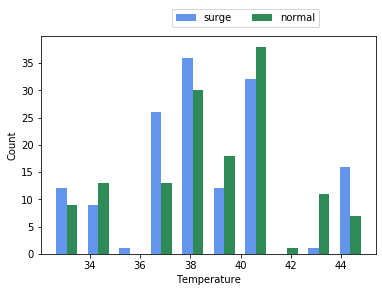

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(surge['temp'])
b_heights, b_bins = np.histogram(normal['temp'].sample(n=150, random_state=1), bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
#seaborn.despine(ax=ax, offset=10)
plt.xlabel('Temperature')
plt.ylabel('Count')
fig.legend(['surge','normal'],bbox_to_anchor =(0.75, 1), ncol = 2)

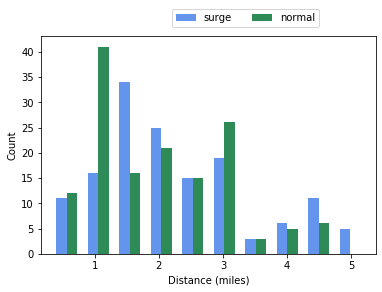

In [74]:
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(surge['distance'])
b_heights, b_bins = np.histogram(normal['distance'].sample(n=150, random_state=1), bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
#seaborn.despine(ax=ax, offset=10)
plt.xlabel('Distance (miles)')
plt.ylabel('Count') 
fig.legend(['surge','normal'],bbox_to_anchor =(0.75, 1), ncol = 2)

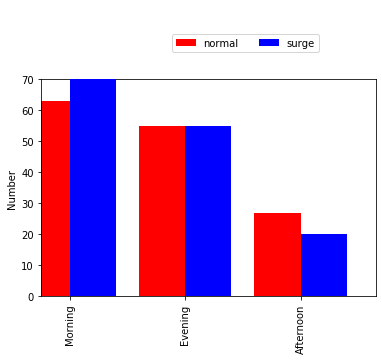

In [64]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

normal['timeofday'].sample(n=145, random_state=1).value_counts().plot(kind='bar', color='red', ax=ax, width=width, position=1)
surge['timeofday'].value_counts().plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Number')
ax.set_ylim([0,70]);
ax2.set_ylim([0,70]);
fig.legend(['normal','surge'],bbox_to_anchor =(0.75, 1.15), ncol = 2)

ax2.axis('off')

plt.show()

In order to determine under what circumstances the surge_multiplier is applied, one would need more data. Plain and simple. Whether surge is related to weather or the time of day , at this point, it is uncertain. All we can do is assume and extrapolate our assumption. However, this is dangerous as human bias is a "guesstimate." 

*On your own* : Try a hypothesis test 